In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import probscale
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
from comet_ml import Experiment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from itertools import cycle

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay
import pickle
sys.path.append('../ift6758/data/')

# 1- Load the tidy v2 train and test datasets

In [2]:
train_2015_2018 = pd.read_csv('./milestone2_csvs/tidy_train_2015_2018.csv')

In [3]:
test_2019_2020 = pd.read_csv('./milestone2_csvs/tidy_test_2019_2020.csv')

In [4]:
train_2015_2018.head()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle,angle_d
0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,6.0,Wrist Shot,NaN,Brad Boyes,Brad Boyes,0,Toronto Maple Leafs,34.5254,0.1747,10.009573
1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-79.0,0.0,Snap Shot,NaN,Nazem Kadri,Nazem Kadri,0,Toronto Maple Leafs,10.0000,0.0000,0.000000
2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-75.0,-1.0,Snap Shot,NaN,Nazem Kadri,Nazem Kadri,0,Toronto Maple Leafs,14.0357,0.0713,4.085189
3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-55.0,-36.0,Wrist Shot,NaN,Daniel Winnik,Daniel Winnik,0,Toronto Maple Leafs,49.5177,0.8140,46.638765
4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,0,-61.0,-1.0,Tip-In,NaN,Joffrey Lupul,Joffrey Lupul,0,Toronto Maple Leafs,28.0179,0.0357,2.045459


In [5]:
train_2015_2018.tail()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle,angle_d
332737,276,15:22,3,2018030417,St. Louis Blues,Boston Bruins,1,-77.0,7.0,Snap Shot,Even,Zach Sanford,Zach Sanford,0,St. Louis Blues,13.8924,0.5281,30.257901
332738,279,15:51,3,2018030417,St. Louis Blues,Boston Bruins,0,-69.0,7.0,Snap Shot,NaN,Alexander Steen,Alexander Steen,0,St. Louis Blues,21.1896,0.3367,19.291489
332739,280,15:55,3,2018030417,St. Louis Blues,Boston Bruins,0,-65.0,-4.0,Snap Shot,NaN,Ryan O'Reilly,Ryan O'Reilly,0,St. Louis Blues,24.3311,0.1651,9.459533
332740,284,16:50,3,2018030417,St. Louis Blues,Boston Bruins,0,42.0,3.0,Wrist Shot,NaN,Marcus Johansson,Marcus Johansson,0,Boston Bruins,47.0956,0.0637,3.649741
332741,289,17:50,3,2018030417,St. Louis Blues,Boston Bruins,1,44.0,24.0,Wrist Shot,Even,Matt Grzelcyk,Matt Grzelcyk,0,Boston Bruins,51.0000,0.4900,28.074932


In [6]:
test_2019_2020.head()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle,angle_d
0,4,00:25,1,2019020001,Ottawa Senators,Toronto Maple Leafs,1,85.0,-1.0,Tip-In,Even,Brady Tkachuk,Brady Tkachuk,0,Ottawa Senators,4.1231,0.2450,14.037466
1,12,01:31,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-32.0,-2.0,Snap Shot,NaN,Morgan Rielly,Morgan Rielly,0,Toronto Maple Leafs,57.0351,0.0351,2.011082
2,19,03:23,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,63.0,-6.0,Snap Shot,NaN,Dylan DeMelo,Dylan DeMelo,0,Ottawa Senators,26.6833,0.2268,12.994683
3,22,03:56,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-59.0,-20.0,Wrist Shot,NaN,Morgan Rielly,Morgan Rielly,0,Toronto Maple Leafs,36.0555,0.5880,33.689918
4,27,04:47,1,2019020001,Ottawa Senators,Toronto Maple Leafs,0,-42.0,-29.0,Slap Shot,NaN,Tyson Barrie,Tyson Barrie,0,Toronto Maple Leafs,55.2268,0.5528,31.673107


In [7]:
test_2019_2020.tail()

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,distance,angle,angle_d
73862,319,16:01,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,-59.0,-24.0,Snap Shot,NaN,Anthony Cirelli,Anthony Cirelli,0,Tampa Bay Lightning,38.4187,0.6747,38.657462
73863,326,17:20,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,-81.0,3.0,Wrist Shot,NaN,Blake Coleman,Blake Coleman,0,Tampa Bay Lightning,8.5440,0.3588,20.557726
73864,333,18:50,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,34.0,-6.0,Snap Shot,NaN,John Klingberg,John Klingberg,0,Dallas Stars,55.3263,0.1087,6.228051
73865,341,19:27,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,31.0,10.0,Wrist Shot,NaN,John Klingberg,John Klingberg,0,Dallas Stars,58.8558,0.1707,9.780390
73866,343,19:45,3,2019030416,Tampa Bay Lightning,Dallas Stars,0,77.0,0.0,Wrist Shot,NaN,Joe Pavelski,Joe Pavelski,0,Dallas Stars,12.0000,0.0000,0.000000


# Task 3- Logistic Regression Model

## Import the environment variables with the credential for pur workspace

In [8]:
import os

In [9]:
api_key = os.getenv('COMET_API_KEY')
project_name = os.getenv('project_name')
workspace = os.getenv('workspace')

## Create a subset of the main dataset with the features (distance and angle) and the label to predict.

In [10]:
goal_data3 = train_2015_2018[['distance','angle','is_goal']]
goal_data3

,distance,angle,is_goal
0,34.5254,0.1747,0
1,10.0000,0.0000,0
2,14.0357,0.0713,0
3,49.5177,0.8140,0
4,28.0179,0.0357,0
...,...,...,...
332737,13.8924,0.5281,1
332738,21.1896,0.3367,0
332739,24.3311,0.1651,0
332740,47.0956,0.0637,0


### Drop all NAN values and define the variables X and Y.

In [11]:
goal_data3 = goal_data3.dropna()

In [12]:
X = np.array(goal_data3[['distance','angle']])
Y = np.array(goal_data3[['is_goal']])
Y = Y.reshape(-1,1)

### Set the random state, in order to make the experiments reproducible. Split in train and validation sets

In [13]:
rng = np.random.RandomState(0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rng)

## Random Baseline

In [15]:
#Uncomment to log experiment.
#experiment = Experiment(
    #api_key= api_key,
    #project_name= project_name,
    #workspace= workspace,
    #log_code=False,
#)
#experiment.add_tag('Task 3: Random Uniform Baseline')

In [16]:
ns_probs = np.random.uniform(low=0.0, high=1.0, size=(len(y_test)))

In [17]:
ns_auc = np.round((roc_auc_score(y_test, ns_probs)),4)

In [18]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

In [19]:
#Uncomment to log experiment's ROC curve.
#experiment.log_curve(f"roc-curve-class- Random Baseline", ns_fpr, ns_tpr)

In [20]:
#End the experiment log.
#experiment.end()

## Experiment 1 - LR Model, trained on distance

In [21]:
#Uncomment to log experiment.
#experiment1 = Experiment(
    #api_key= api_key,
    #project_name= project_name,
    #workspace= workspace,
    #log_code=False,
#)
#experiment1.add_tag('Task 3: Logistic Regression - Distance')

In [22]:
X_train_1 = X_train[:,0]
X_train_1 = X_train_1.reshape(-1,1)
X_test_1 = X_test[:,0]
X_test_1 = X_test_1.reshape(-1,1)

In [23]:
X_train_2 = X_train[:,1]
X_train_2 = X_train_2.reshape(-1,1)
X_test_2 = X_test[:,1]
X_test_2 = X_test_2.reshape(-1,1)

In [24]:
X_train_3 = X_train
X_test_3 = X_test

In [25]:
np.shape(X_train_1)

(266177, 1)

In [26]:
logistic = LogisticRegression()
logistic.fit(X_train_1,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [27]:
y_pred_1 = logistic.predict(X_test_1)

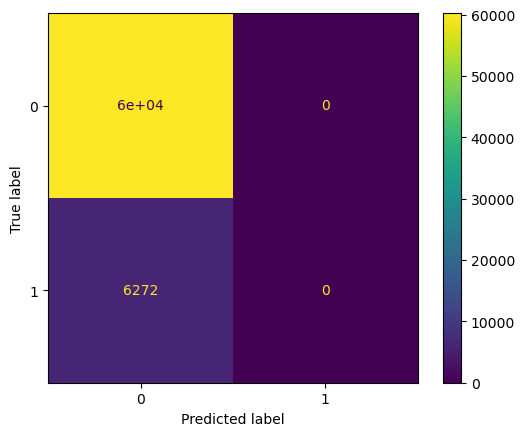

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1)

In [29]:
np.unique(y_pred_1)

array([0])

In [30]:
acc_ex1 = accuracy_score(y_test,y_pred_1)
#Uncomment to log experiment's accuracy metric.
#experiment1.log_metric("validation accuracy LR Shot's Distance", acc_ex1)
acc_ex1

0.9057479900818994

In [31]:
prob_1_predicted = logistic.predict_proba(X_test_1)

In [32]:
prob_1_predicted

array([[0.81042303, 0.18957697],
       [0.96680626, 0.03319374],
       [0.90917433, 0.09082567],
       ...,
       [0.9658731 , 0.0341269 ],
       [0.95466476, 0.04533524],
       [0.85717887, 0.14282113]])

In [33]:
lr1_probs = prob_1_predicted
lr1_probs = lr1_probs[:, 1]

In [34]:
lr1_auc = np.round((roc_auc_score(y_test, lr1_probs)),4)
#Uncomment to log experiment's accuracy metric.
#experiment1.log_metric("AUC Score LR Shot's Distance", lr1_auc)

In [35]:
lr1_fpr, lr1_tpr, _ = roc_curve(y_test, lr1_probs)

In [36]:
#Uncomment to log experiment's ROC curve.
#experiment1.log_curve(f"roc-curve-class- Logistic Regression Distance",lr1_fpr, lr1_tpr)

In [37]:
#Uncomment to save trained model.
#with open('lr1_pkl.pickle', 'wb') as files:
    #pickle.dump(logistic, files, pickle.HIGHEST_PROTOCOL)

In [38]:
#Uncomment to log experiment's model and have it available as an artifact.
#experiment1.log_model("LR_distance", "lr1_pkl.pickle")

In [39]:
#Uncomment to end experiment.
#experiment1.end()

## Experiment 2: LR Model, trained with the angle

In [40]:
#Uncomment to log experiment.
#experiment2 = Experiment(
    #api_key= api_key,
    #project_name= project_name,
    #workspace= workspace,
    #log_code=False,
#)
#experiment2.add_tag('Task 3: Logistic Regression - Angle')

In [41]:
logistic2 = LogisticRegression()
logistic2.fit(X_train_2,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

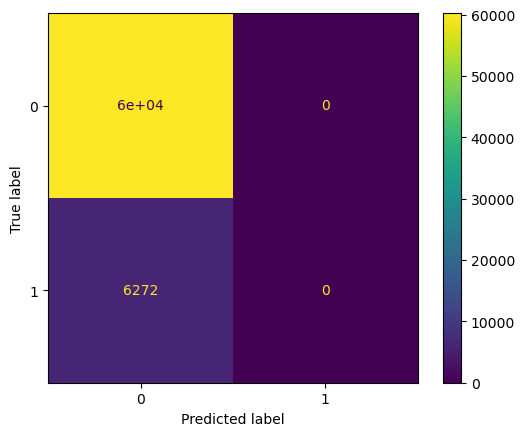

In [42]:
y_pred_2 = logistic2.predict(X_test_2)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2)

In [43]:
acc_ex2 = accuracy_score(y_test,y_pred_2)
#Uncomment to log experiment's metric.
#experiment2.log_metric("validation accuracy LR Shot's Angle", acc_ex2)
acc_ex2

0.9057479900818994

In [44]:
prob_2_predicted = logistic2.predict_proba(X_test_2)

In [45]:
prob_2_predicted 

array([[0.89758362, 0.10241638],
       [0.8958518 , 0.1041482 ],
       [0.90915072, 0.09084928],
       ...,
       [0.8796834 , 0.1203166 ],
       [0.89824648, 0.10175352],
       [0.89376864, 0.10623136]])

In [46]:
lr2_probs = prob_2_predicted
lr2_probs = lr2_probs[:, 1]

In [47]:
lr2_auc = np.round((roc_auc_score(y_test, lr2_probs)),4)
#Uncomment to log experiment's metric.
#experiment2.log_metric("AUC Score LR Shot's Angle", lr2_auc)

In [48]:
lr2_fpr, lr2_tpr, _ = roc_curve(y_test, lr2_probs)

In [49]:
#Uncomment to log experiment's ROC curve.
#experiment2.log_curve(f"roc-curve-class- Logistic Regression Angle",lr2_fpr, lr2_tpr)

In [50]:
#Uncomment to save experiment's trained model.
#with open('lr2_pkl.pickle', 'wb') as files:
    #pickle.dump(logistic2, files, pickle.HIGHEST_PROTOCOL)

In [51]:
#Uncomment to log experiment's trained model.
#experiment2.log_model("LR_angle", "lr2_pkl.pickle")

In [52]:
#Uncomment to end experiment
#experiment2.end()

## Experiment 3: LR Model - Trained with the distance and angle features

In [53]:
#Uncomment to log experiment.
#experiment3 = Experiment(
    #api_key= api_key,
    #project_name= project_name,
    #workspace= workspace,
    #log_code=False,
#)
#experiment3.add_tag('Task 3: Logistic Regression - Distance + Angle')

In [54]:
logistic3 = LogisticRegression()
logistic3.fit(X_train_3,y_train)

/home/nexus10/miniconda3/envs/ift6758-conda-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

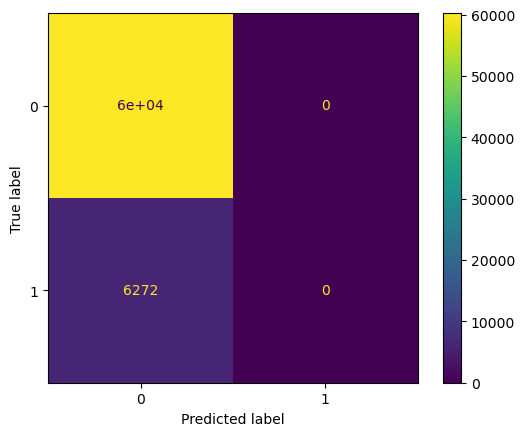

In [55]:
y_pred_3 = logistic3.predict(X_test_3)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3)

In [56]:
acc_ex3 = accuracy_score(y_test,y_pred_3)
#Uncomment to log experiment's metric.
#experiment3.log_metric("validation accuracy LR Shot's Distance and Angle", acc_ex3)
acc_ex3

0.9057479900818994

In [57]:
prob_3_predicted = logistic3.predict_proba(X_test_3)

In [58]:
prob_3_predicted

array([[0.78460872, 0.21539128],
       [0.96252012, 0.03747988],
       [0.91134273, 0.08865727],
       ...,
       [0.95340372, 0.04659628],
       [0.94994657, 0.05005343],
       [0.83095538, 0.16904462]])

In [59]:
lr3_probs = prob_3_predicted
lr3_probs = lr3_probs[:, 1]

In [60]:
lr3_auc = np.round((roc_auc_score(y_test, lr3_probs)),4)
#Uncomment to log experiment's metric.
#experiment3.log_metric("AUC Score LR Shot's Distance and Angle", lr3_auc)

In [61]:
lr3_fpr, lr3_tpr, _ = roc_curve(y_test, lr3_probs)

In [62]:
#Uncomment to log experiment's ROC.
#experiment3.log_curve(f"roc-curve-class- Logistic Regression Dist + Ang",lr3_fpr, lr3_tpr)

In [63]:
#Uncomment to save experiment's trained model.
#with open('lr3_pkl.pickle', 'wb') as files:
    #pickle.dump(logistic3, files, pickle.HIGHEST_PROTOCOL)

In [64]:
#Uncomment to log experiment's trained model.
#experiment3.log_model("LR_distance_angle", "lr3_pkl.pickle")

In [65]:
#Uncomment to end experiment.
#experiment3.end()

# Task 3: Experiment Evaluation Plots

## ROC Plots

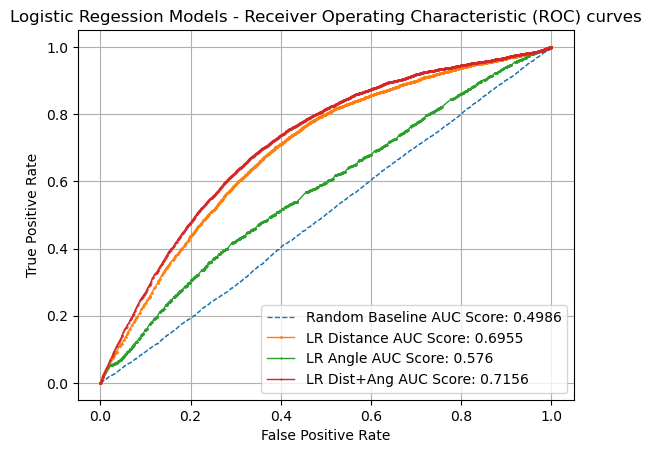

In [66]:
plt.plot(ns_fpr, ns_tpr, linestyle='--',linewidth=1, markersize=1, label=f"Random Baseline AUC Score: {ns_auc}")
plt.plot(lr1_fpr, lr1_tpr, marker='o', linewidth=1, markersize=1,label=f"LR Distance AUC Score: {lr1_auc}")
plt.plot(lr2_fpr, lr2_tpr, marker='*', linewidth=1, markersize=1,label=f"LR Angle AUC Score: {lr2_auc}")
plt.plot(lr3_fpr, lr3_tpr, marker='.', linewidth=1, markersize=1,label=f"LR Dist+Ang AUC Score: {lr3_auc}")
plt.title('Logistic Regession Models - Receiver Operating Characteristic (ROC) curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

## Goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile

In [67]:
df_prob_goals = pd.DataFrame()

In [68]:
df_prob_goals['y_prob_rm'] = ns_probs
df_prob_goals['y_prob_lr1'] = lr1_probs
df_prob_goals['y_prob_lr2'] = lr2_probs
df_prob_goals['y_prob_lr3'] = lr3_probs
df_prob_goals['y_test'] = y_test

In [69]:
df_prob_goals.head()

,y_prob_rm,y_prob_lr1,y_prob_lr2,y_prob_lr3,y_test
0,0.825622,0.189577,0.102416,0.215391,0
1,0.564576,0.033194,0.104148,0.037480,0
2,0.147721,0.090826,0.090849,0.088657,0
3,0.188551,0.105318,0.048858,0.048772,0
4,0.239351,0.154320,0.107950,0.185893,1


In [70]:
d = np.sort(df_prob_goals['y_prob_rm'])
d1 = np.sort(df_prob_goals['y_prob_lr1'])
d2 = np.sort(df_prob_goals['y_prob_lr2'])
d3 = np.sort(df_prob_goals['y_prob_lr3'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0,100.0])


perc = np.percentile(d, p)
perc1 = np.percentile(d1, p)
perc2 = np.percentile(d2, p)
perc3 = np.percentile(d3, p)

In [71]:
def plot_gr_perc():
    x = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_rm'], bins=perc).reset_index()
    x =x.groupby('y_prob_rm', as_index=False).size()
    x.columns = ['y_prob_rm', 'count']

    y = pd.cut(df_prob_goals['y_prob_rm'], bins=perc).reset_index()
    y =y.groupby('y_prob_rm', as_index=False).size()
    y.columns = ['y_prob_rm', 'count']

    x1 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr1'], bins=perc1).reset_index()
    x1 =x1.groupby('y_prob_lr1', as_index=False).size()
    x1.columns = ['y_prob_lr1', 'count']

    y1 = pd.cut(df_prob_goals['y_prob_lr1'], bins=perc1).reset_index()
    y1 =y1.groupby('y_prob_lr1', as_index=False).size()
    y1.columns = ['y_prob_lr1', 'count']

    x2 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr2'], bins=perc2).reset_index()
    x2 =x2.groupby('y_prob_lr2', as_index=False).size()
    x2.columns = ['y_prob_lr2', 'count']

    y2 = pd.cut(df_prob_goals['y_prob_lr2'], bins=perc2).reset_index()
    y2 =y2.groupby('y_prob_lr2', as_index=False).size()
    y2.columns = ['y_prob_lr2', 'count']

    x3 = pd.cut(df_prob_goals[df_prob_goals['y_test'] == 1]['y_prob_lr3'], bins=perc3).reset_index()
    x3 =x3.groupby('y_prob_lr3', as_index=False).size()
    x3.columns = ['y_prob_lr3', 'count']

    y3 = pd.cut(df_prob_goals['y_prob_lr3'], bins=perc3).reset_index()
    y3 =y3.groupby('y_prob_lr3', as_index=False).size()
    y3.columns = ['y_prob_lr3', 'count']

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x['count'] / y['count']), label = 'Random Uniform Baseline')
    sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x1['count'] / y1['count']), label = 'LR Model - Distance')
    sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x2['count'] / y2['count']), label = 'LR Model - Angle')
    sns.lineplot(x=[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,95.0], y = 100*(x3['count'] / y3['count']), label = 'LR Model - Dist + Ang')
    plt.title('Goal rate vs shot probabilty model percentile')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Goal rate")
    #ax.set_yscale('prob')
    fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    plt.gca().yaxis.set_major_formatter(yticks)
    plt.gca().invert_xaxis()
    plt.grid()
    plt.xticks(np.arange(0, 101, 10.0))
    plt.yticks(np.arange(0, 101, 10.0))

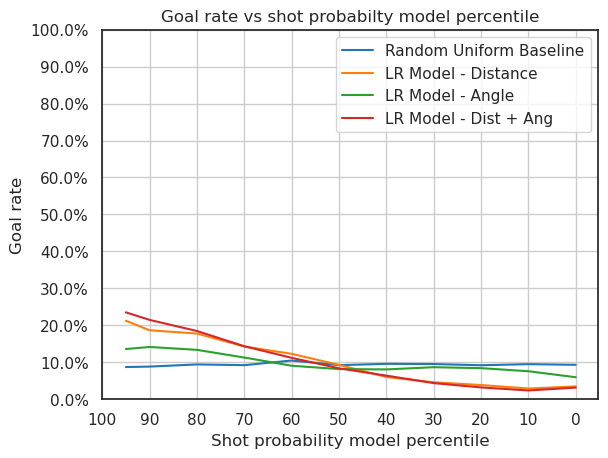

In [72]:
plot_gr_perc()

## Cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

In [73]:
goals = df_prob_goals[df_prob_goals['y_test']==1]

In [74]:
goals

,y_prob_rm,y_prob_lr1,y_prob_lr2,y_prob_lr3,y_test
4,0.239351,0.154320,0.107950,0.185893,1
5,0.673989,0.205681,0.050436,0.107340,1
21,0.498638,0.142821,0.106231,0.169045,1
26,0.690739,0.019325,0.093143,0.018559,1
45,0.756759,0.074433,0.086148,0.067585,1
...,...,...,...,...,...
66477,0.646285,0.053034,0.111127,0.065772,1
66494,0.844937,0.074433,0.086148,0.067585,1
66496,0.777669,0.133782,0.085432,0.123082,1
66515,0.823297,0.079595,0.094729,0.081463,1


In [75]:
d_0 = np.sort(goals['y_prob_rm'])
d_1 = np.sort(goals['y_prob_lr1'])
d_2 = np.sort(goals['y_prob_lr2'])
d_3 = np.sort(goals['y_prob_lr3'])

# Percentile values
p = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0,80.0,90.0,100.0])


perc_0 = np.percentile(d_0, p)
perc_1 = np.percentile(d_1, p)
perc_2 = np.percentile(d_2, p)
perc_3 = np.percentile(d_3, p)

In [76]:
def plot_partition_perc():
    x = pd.cut(goals['y_prob_rm'], bins=perc_0).reset_index()
    x =x.groupby('y_prob_rm', as_index=False).size()
    x.columns = ['y_prob_rm', 'count']

    x1 = pd.cut(goals['y_prob_lr1'], bins=perc_1).reset_index()
    x1 =x1.groupby('y_prob_lr1', as_index=False).size()
    x1.columns = ['y_prob_lr1', 'count']

    x2 = pd.cut(goals['y_prob_lr2'], bins=perc_2).reset_index()
    x2 =x2.groupby('y_prob_lr2', as_index=False).size()
    x2.columns = ['y_prob_lr2', 'count']


    x3 = pd.cut(goals['y_prob_lr3'], bins=perc_3).reset_index()
    x3 =x3.groupby('y_prob_lr3', as_index=False).size()
    x3.columns = ['y_prob_lr3', 'count']

    z = len(goals['y_test'])

    sns.set_theme(style="white", palette=None)
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100']), y = (np.flip((x['count']/z))).cumsum(), label = 'Random Uniform Baseline')
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100']), y = (np.flip((x1['count']/z))).cumsum(), label = 'LR Model - Distance')
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100']), y = (np.flip((x2['count']/z))).cumsum(), label = 'LR Model - Angle')
    sns.lineplot(x=np.flip(['10','20','30','40','50','60','70','80','90','100']), y = (np.flip((x3['count']/z))).cumsum(), label = 'LR Model - Dist + Ang')
    plt.title('Cumulative proportion of Goals vs shot probabilty model percentile')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel("Proportion")
    plt.yscale('prob')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    #fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
    #yticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().yaxis.set_major_formatter(yticks)
    #xticks = mtick.FormatStrFormatter(fmt)
    #plt.gca().xaxis.set_major_formatter(xticks)
    #plt.gca().invert_xaxis()
    plt.grid()

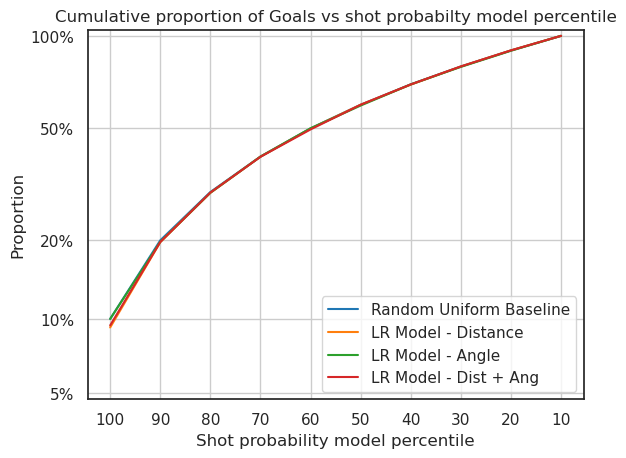

In [77]:
plot_partition_perc()

## Calibration Plot

In [78]:
logreg1_y, logreg1_x = calibration_curve(y_test, lr1_probs, n_bins=20)
logreg2_y, logreg2_x = calibration_curve(y_test, lr2_probs, n_bins=20)
logreg3_y, logreg3_x = calibration_curve(y_test, lr3_probs, n_bins=20)
rc_y, rc_x = calibration_curve(y_test, ns_probs, n_bins=20)

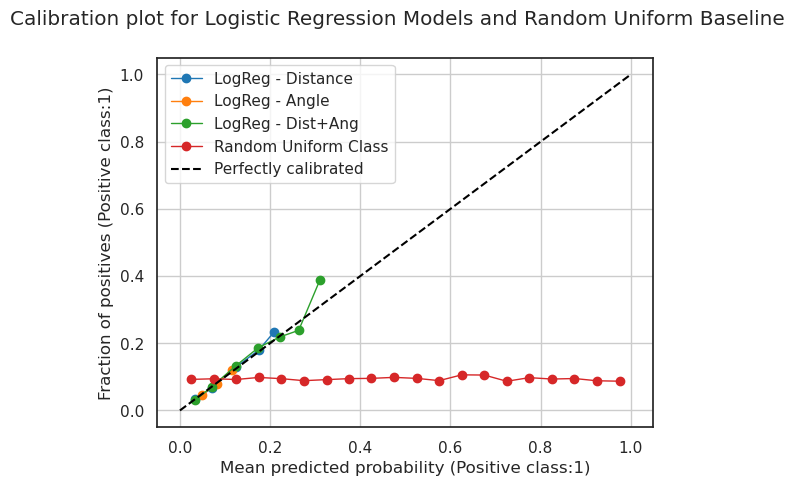

In [79]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg1_x,logreg1_y, marker='o', linewidth=1, label='LogReg - Distance')
plt.plot(logreg2_x,logreg2_y, marker='o', linewidth=1, label='LogReg - Angle')
plt.plot(logreg3_x,logreg3_y, marker='o', linewidth=1, label='LogReg - Dist+Ang')
plt.plot(rc_x, rc_y, marker='o', linewidth=1, label='Random Uniform Class')

# reference line, legends, and axis labels
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
fig.suptitle('Calibration plot for Logistic Regression Models and Random Uniform Baseline')
ax.set_xlabel('Mean predicted probability (Positive class:1)')
ax.set_ylabel('Fraction of positives (Positive class:1)')
plt.grid()
plt.legend()
plt.show()